##22.46 Procesamiento Adaptativo de Señales Aleatorias
###Laboratorio de predicción lineal. Grupo 2

###© 2019 Juan Manuel Romarís 
###© 2019 Lucero G. Fernandez


##Imports de Paquetes utilizados y definición de Funciones

In [0]:
%cd /content
from IPython.display import clear_output

!wget "https://raw.githubusercontent.com/LuFernandez/PASA/master/TP3/ahhsound.wav"
!wget "https://raw.githubusercontent.com/LuFernandez/PASA/master/TP3/ahhsound2.wav"
!wget "https://raw.githubusercontent.com/LuFernandez/PASA/master/TP3/shhsound.wav"
clear_output()

import warnings
warnings.filterwarnings("ignore")
from scipy.io.wavfile import read
import numpy as np
from scipy import fftpack as scfft
import IPython.display as ipd
import matplotlib.pyplot as plt
import wave, struct, math, random
from IPython.display import Audio
from scipy import signal as sgn
from scipy.linalg import toeplitz
from scipy import linalg
from scipy import signal
from scipy.io.wavfile import write

Definimos algunas funcionas auxiliares para la lectura de los archivos de audio y de ploteo de datos

In [0]:
!pip install soundfile
import soundfile as sf
def fast_plot(data):
    plt.plot(range(len(data)),data)
def normalize(datos):
    return np.interp(datos, (datos.min(), datos.max()), (-1, +1)) #normalizamos
def get_mono_array(stereo_file_name):
    file = read(stereo_file_name)
    fs = file[0]
    datos = np.array(file[1],dtype=float) 
    if len(np.shape(datos))>1: #si tiene dos canales
        ch0 = datos[:, 0]
        ch1 = datos[:, 1]
        datos = (ch0 + ch1)/2  # o lo hacemos mono
    return fs, datos

clear_output()


###Definición de funciones utilizadas

In [0]:
#Vector que contiene los ordenes de filtro a implementar
Ms=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,25,30,35,40,45,50,55,60,65,70,75,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100]

#Función utilizada para leer un archivo wav
def read_wav(grab_file):
  file_name = grab_file
  fs, grab_audio = get_mono_array(file_name)
  grab_audio /= np.max(np.abs(grab_audio),axis=0)
  grab_audio /= np.max(np.abs(grab_audio),axis=0)
  grab_audio = grab_audio - np.mean(grab_audio)
  print("fs de la grabacion ",fs, "nombre", file_name)
  return grab_audio,fs


#Dada una autocorrelación r y un orden M se obtiene el error de predicción lineal
def get_error(r,M):
    R=toeplitz(r[0:M])
    rx=r[1:M+1]
    r0=r[0]
    wo = np.dot(linalg.inv(R), rx)
    PM= r0-rx.dot(wo)
    return PM

#Esta función calcula el error de predicción lineal para los distintos ordenes de filtro deseados
def get_lineal_predictor(u):
    fullPM= np.zeros(len(Ms))
    u_f = np.fft.fft(u)
    ##Estimo rx
    r = np.fft.ifft(u_f * u_f.conj()).real
    r = r[:len(u)//2]/len(u)
    for i in range(len(Ms)):
        fullPM[i]=get_error(r,Ms[i])
    return fullPM

#Dada una señal de entrada y un orden Deseado esta función devuelve el filtro predictor asociado
def get_filter(u,M):
    u_f = np.fft.fft(u)
    ##Estimo rx
    r = np.fft.ifft(u_f * u_f.conj()).real
    r = r[:len(u)//2]/len(u)
    R=toeplitz(r[0:M])
    rx=r[1:M+1]
    #obtengo los coefs del filtro
    wo = np.dot(linalg.inv(R), rx)
    return wo


#Dada una señal de entrada y un orden de filtro deseado esta función aplica el algoritmo de Levinson-Durbin
def levinson_durbin(u,M):
    u_f = np.fft.fft(u)
    ##Estimo rx
    r = np.fft.ifft(u_f * u_f.conj()).real
    r = r[:len(u)//2]/len(u)
    k_m=np.zeros(M+1)
    a_m_k=np.zeros((M+1,M+1))
    
    delta_m=np.zeros(M+1)
    P_m=np.zeros(M+1)
    #inicializo
    a_m_k[0][0]=1
    P_m[0]=r[0]
    delta_m[0]=np.conj(r[1])
    #Aplico el algoritmo
    for m in range(1,M+1):
      k_m[m]=-delta_m[m-1]/P_m[m-1]
      a_m_k[m][0]=1
      for k in range(1,m+1):
        a_m_k[m][k]=a_m_k[m-1][k]+k_m[m]*a_m_k[m-1][m-k]
      delta_m[m]=r[m+1]+np.dot(a_m_k[m][1:m+1],np.flip(r[1:m+1]))
      P_m[m]=P_m[m-1]*(1-k_m[m]**2)
    return a_m_k[M][:], P_m

##Cálculo del predictor lineal para distintos audios

###Señal de voz con sonido /ahh/

En primer lugar se consideró trabajar con la señal de audio con el sonido $/ahh/$. Se obtuvo una grabación de la misma de 2 segundos a una frecuencia de muestreo de 8kHz. A continuación se puede escuchar el audio grabado:

In [4]:
ah_audio,fs=read_wav("/content/ahhsound.wav")
Audio(ah_audio,rate=fs)

fs de la grabacion  8000 nombre /content/ahhsound.wav


Dada esta grabación se consideró obtener el filtro de predicción lineal forward con $No=1$ para distintas longitudes de filtro. Para estos distintos filtros se consideró obtener el error cuadrático medio de predicción forward $P_M$ y se lo graficó en función del orden del filtro, obteniéndose:

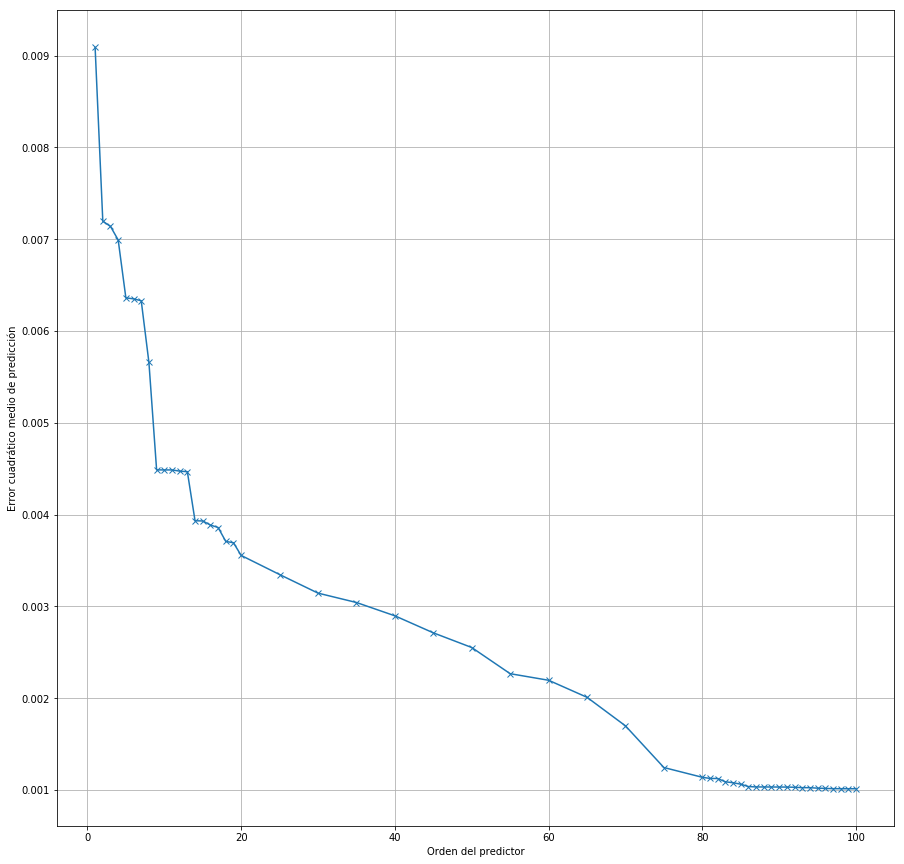

In [5]:
fullPM= get_lineal_predictor(ah_audio)
plt.figure(figsize=(15,15))
plt.xlabel("Orden del predictor")
plt.ylabel("Error cuadrático medio de predicción")
plt.grid(True,which='both')
plt.plot(Ms,fullPM, marker='x')

Se observa que para algunas longitudes de filtro de bajos ordenes el error de predicción lineal presenta saltos muy notables($M$=1,7,13).

Después de estos primeros saltos considerables el error de predicción sigue mejorando a medida que incrementa el tamaño del filtro pero las mejoras son menos notorias. Se observa que para ordenes mayores a 85 las mejores son casi nulas y puede considerarse que el filtro converge a ese valor.

####Filtro autorregresivo estimado

Habiendo obtenido la curva del error de predición para el sonido en cuestión se consideró estimar el filtro Auto regresivo con el que se puede modelar el sonido vocal utilizado.

In [0]:
#plotea espectro
def fftPlot(fs, data, title, m):
  # cantidad de muestras
  N = len(data)
  z = scfft.fft(x=data, n=N)
  Z = np.power(np.abs(z), 2)
  Z /= sum(Z)
  freqs = np.fft.fftfreq(N)
  xf = np.linspace(0, fs/2, N//2)    #frecuencias
  plt.semilogx(xf, 2/N * np.abs(Z[:N//2]))
  # plt.xlim(x_lim)
  plt.grid()
  plt.title(title)
  plt.xlabel("Frequency (Hz)")
  plt.ylabel("H(f)")

In [0]:
#Dado los coeficientes de un filtro de predicción lineal esta función estima los coeficientes del modelo AR asociado
def estimate_error_filter(wo, u):
  M = len(wo)
  ak = np.zeros(M+1)
  fM = np.zeros(len(u))
  ak[0] = 1   #k=0
  ak[1:] = -wo  #k=1,2,...,M
  for n in range(M+1, len(u)):
    fM[n] = np.dot(ak,u[n-M-1:n])
  return fM #sgn.filtfilt(ak,[1],u)

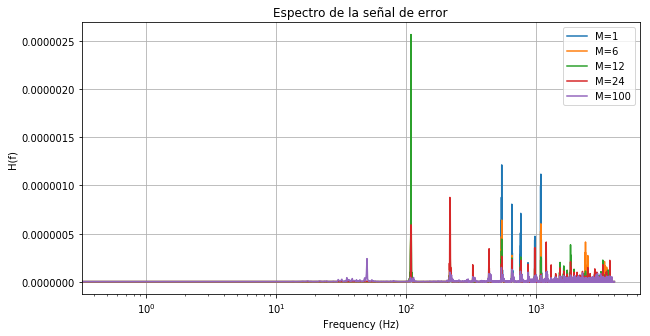

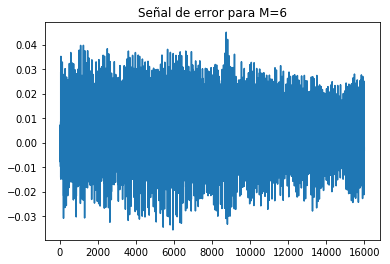

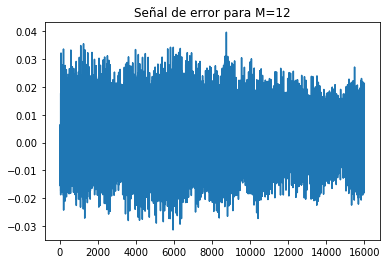

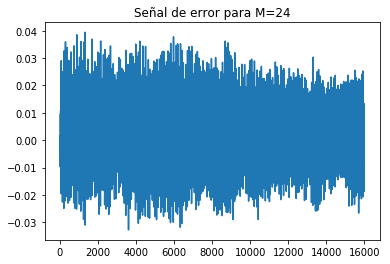

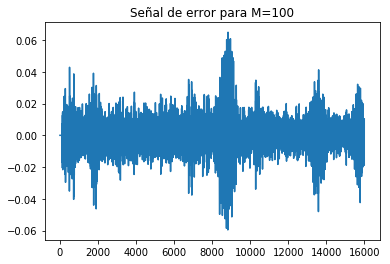

In [20]:
#calculo con M=[1, 6, 12, 24, 100]
Mf = [1, 6, 12, 24, 100]
plt.figure(figsize=(10, 5))
for m in Mf:
  wo = get_filter(ah_audio,m)
  fM = estimate_error_filter(wo,ah_audio)
  fftPlot(fs, fM, 'Espectro de la señal de error', m=m)
  plt.legend( ['M=1', 'M=6', 'M=12', 'M=24', 'M=100'])

Mf = [6, 12, 24, 100]
for m in Mf:
  wo = get_filter(ah_audio,m)
  fM = estimate_error_filter(wo,ah_audio)
  plt.figure()
  plt.plot(fM/np.linalg.norm(fM))
  plt.title('Señal de error para M='+str(m))
  

Se puede observar que al aumentar el orden del filtro el espectro se asemeja más aun espectro plano, suavizando los deltas.
Además, la señal de error disminuye en amplitud al aumentar el orden, por lo que la predicción será mejor. 

####Sintetización de Audio a partir del AR

El orden óptimo en cada caso se obtiene a partir del gráfico de $J_{min}$ ($P_M$)  en función de  $M$. El orden óptimo es aquel para el cual no se observa una mejora apreciable del error. Para este caso, se tomó un orden óptimo de $M_o=85$.

In [9]:
Mo=85
#Calculo el filtro del error de predicción para el orden óptimo
m = Ms.index(Mo)
N=len(ah_audio)
wo= get_filter(ah_audio, Mo)
PM = get_lineal_predictor(ah_audio)
ak = np.ones(Mo+1)
ak[1:] = -wo

#ruido blanco con varianza igual a Jmin
est = np.zeros(N+len(ak))
noise = np.random.normal(0,np.sqrt(PM[m]), N+Mo+1)

#sintetizamos
for n in range(Mo+1,N+Mo+1):
  est[n] = sum([-ak[k]*est[n-k] for k in range(Mo+1)]) + noise[n]
est = est[Mo+1:]

Audio(data=est,rate=fs)

####Levinson-Durbin

Para el valor de $M_o$ obtenido se consideró aplicar el algoritmo de Levinson-Durbin con el fin de poder corroborar el funcionamiento del mismo.

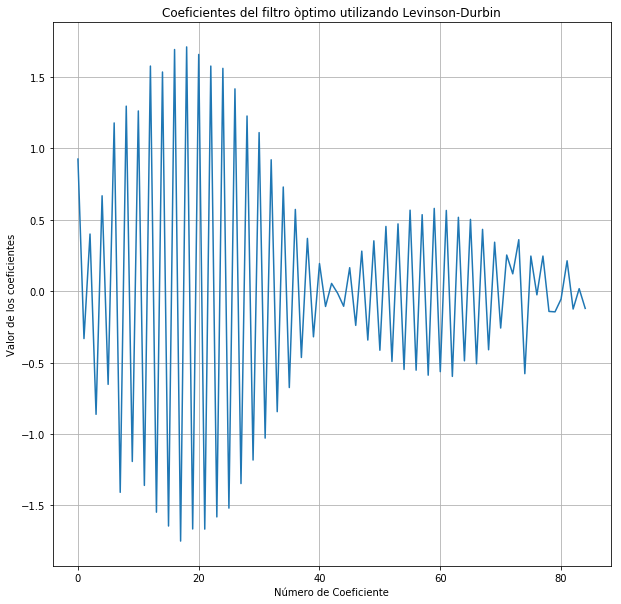

In [10]:
M_optimo=85
w_temp= get_filter(ah_audio,M_optimo)
coefs,PM=levinson_durbin(ah_audio,M_optimo)
plt.figure(figsize=(10,10))
plt.grid()
plt.title("Coeficientes del filtro òptimo utilizando Levinson-Durbin")
plt.xlabel("Número de Coeficiente")
plt.ylabel("Valor de los coeficientes")
plt.plot(range(0,85),-coefs[1:])


Habiendo obtenido los coeficientes del filtro por Levinson-Durbin se consideró compararlos con los obtenidos utilizando la inversión matricial de lo que se obtuvo

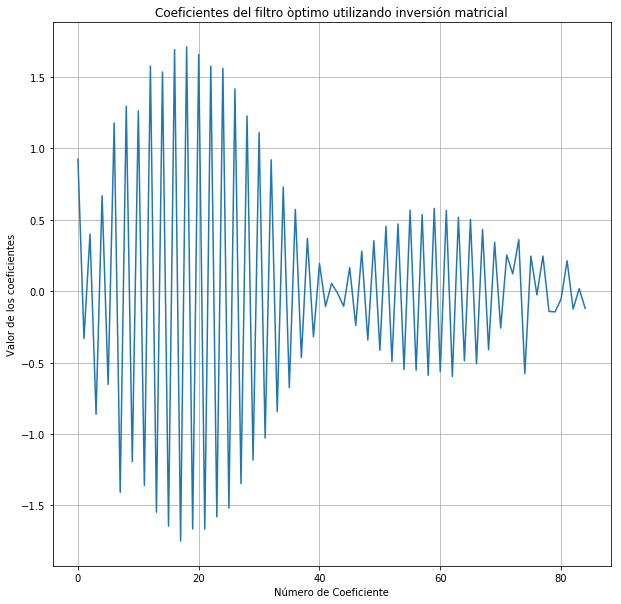

In [11]:
plt.figure(figsize=(10,10))
plt.grid()
plt.title("Coeficientes del filtro òptimo utilizando inversión matricial")
plt.xlabel("Número de Coeficiente")
plt.ylabel("Valor de los coeficientes")
plt.plot(range(0,85),w_temp)

Donde se corrobora que los coeficientes obtenidos son los mismos sin importar el algoritmo utilizado para obtener los coeficientes.

###Señal de voz con sonido /sh/

Luego se consideró trabajar con la señal de audio con el sonido $/shh/$. Se obtuvo una grabación de la misma de 2 segundos a una frecuencia de muestreo de 8kHz. A continuación se puede escuchar el audio grabado:

In [12]:
sh_audio,fs = read_wav("/content/shhsound.wav")
Audio(sh_audio,rate=fs)

fs de la grabacion  8000 nombre /content/shhsound.wav


Dada esta grabación se consideró obtener el filtro de predicción lineal forward con $No=1$ para distintas longitudes de filtro. Para estos distintos filtros se consideró obtener el error cuadrático medio de predicción forward PM y se lo graficó en función del orden del filtro, obteniéndose:

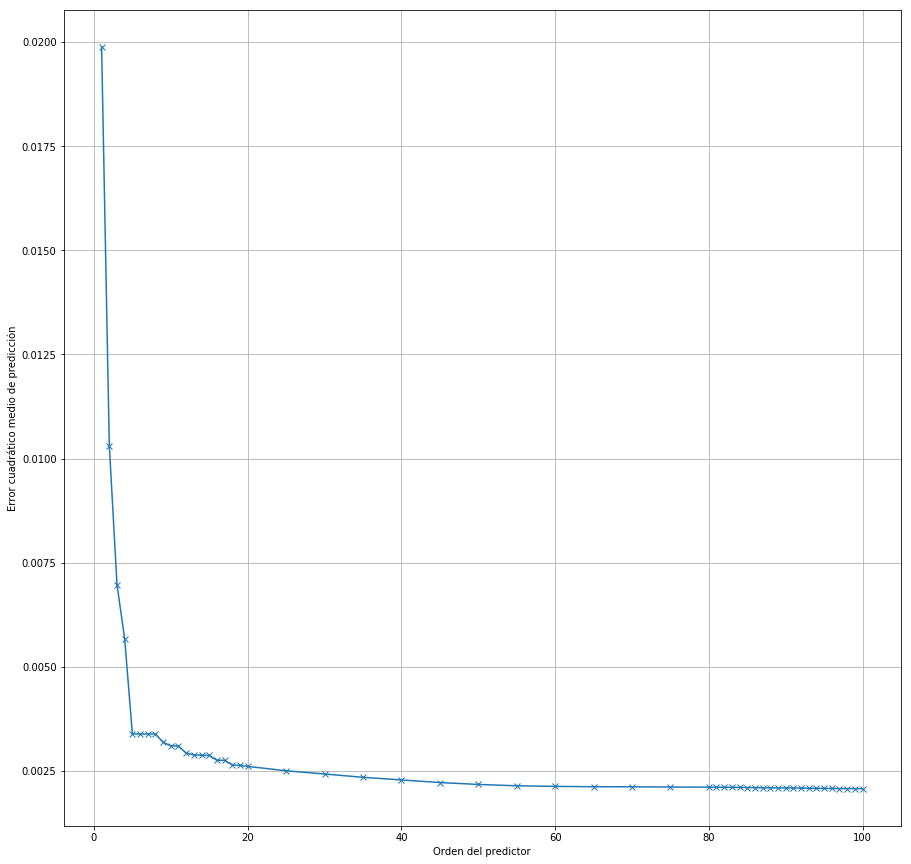

In [13]:
fullPM= get_lineal_predictor(sh_audio)
plt.figure(figsize=(15,15))
plt.xlabel("Orden del predictor")
plt.ylabel("Error cuadrático medio de predicción")
plt.grid(True,which='both')
plt.plot(Ms,fullPM, marker='x')

Para este sonido también se encuentra una muy rápida mejoría del error de predicción respecto al caso del filtro unitario. También se encuentra que la mejora del error es más notable para los ordenes de filtro más pequeños.

A diferencia del caso del sonido $/ahh/$ se encuentra que el orden para el cual la mejora pasa a ser bastante menos notable se reduce en orden pasando aproximadamente orden 40.

####Filtro autorregresivo estimado

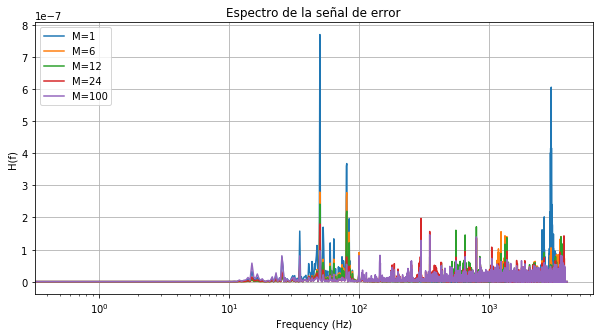

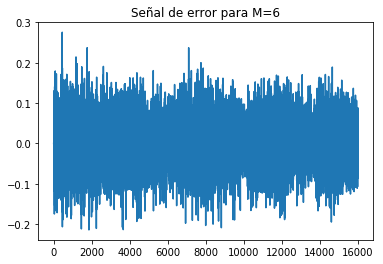

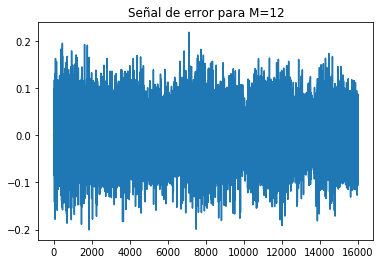

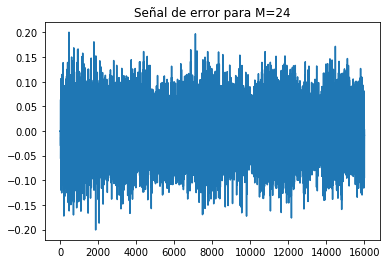

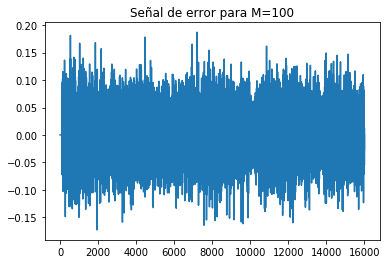

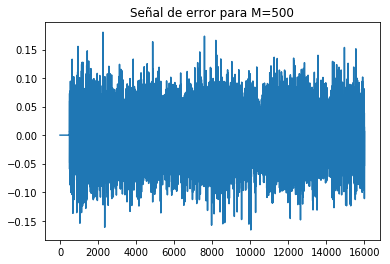

In [27]:
#calculo con M=[1, 6, 12, 24, 100]
Mf = [1, 6, 12, 24, 100]
plt.figure(figsize=(10, 5))
for m in Mf:
  wo = get_filter(sh_audio,m)
  fM = estimate_error_filter(wo,sh_audio)
  fftPlot(fs, fM, 'Espectro de la señal de error', m=m)
  plt.legend( ['M=1', 'M=6', 'M=12', 'M=24', 'M=100'])

Mf = [6, 12, 24, 100, 500]
for m in Mf:
  wo = get_filter(sh_audio,m)
  fM = estimate_error_filter(wo,sh_audio)
  plt.figure()
  plt.plot(fM)
  plt.title('Señal de error para M='+str(m))

Se puede observar que al aumentar el orden del filtro el espectro se asemeja más aun espectro plano, suavizando los deltas.
Si bien en las señales de error, con filtros de orden 6-100 no se observa una notable mejoría a simple vista, por lo que se probó con un orden de 500, notando una disminución en la señal de error con el incremento del orden.

####Sintetización de Audio a partir del AR

El orden óptimo en cada caso se obtiene a partir del gráfico de $J_{min}$ ($P_M$)  en función de  $M$. El orden óptimo es aquel para el cual no se observa una mejora apreciable del error. Para este caso, se tomó un orden óptimo de $M_o=40$.

In [28]:
Mo=40
#Calculo el filtro del error de predicción para el orden óptimo
m = Ms.index(Mo)
N=len(sh_audio)
wo= get_filter(sh_audio, Mo)
PM = get_lineal_predictor(sh_audio)
ak = np.ones(Mo+1)
ak[1:] = -wo

#ruido blanco con varianza igual a Jmin
est = np.zeros(N+Mo+1)
noise = np.random.normal(0,np.sqrt(PM[m]), N+Mo+1)

#sintetizamos
for n in range(Mo+1,N+Mo+1):
  est[n] = sum([-ak[k]*est[n-k] for k in range(Mo+1)]) + noise[n]
est = est[Mo+1:]

Audio(data=est,rate=fs)